In [1]:
from datetime import date
from glob import glob
import json
import math
import os
import pickle
import sys
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import integrate, interpolate, stats

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
%matplotlib notebook

In [5]:
areas_of_interest = {
    'MO': ['MOp1', 'MOp2/3', 'MOp5', 'MOp6a', 'MOp6b', 'MOs1', 'MOs2/3', 'MOs5', 'MOs6a', 'MOs6b'],
    'MO-TH': ['AV', 'CL', 'MD', 'PO', 'PF', 'VAL', 'VPL', 'VPM', 'VM'],
    'RT': ['RT'],
}
areacolors = {'MO': 'blueviolet', 'MO-TH': 'limegreen', 'RT': 'salmon'}

#### Functions

In [6]:
def get_zFR(trig_FR, FRtime):
    
    trig_Z = np.zeros_like(trig_FR) * np.nan # try NaNs, it works
    baseline_avg = np.mean(trig_FR[FRtime < 0, :], axis=0)
    baseline_std = np.std(trig_FR[FRtime < 0, :], axis=0)
    nonzero_inds = np.nonzero(baseline_std)[0]
    trig_Z[:, nonzero_inds] = (trig_FR[:, nonzero_inds] - baseline_avg[None, nonzero_inds]) / baseline_std[None, nonzero_inds]
    
    return trig_Z

#### Set plot directory

In [7]:
plotsavedir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\GAT1-KO_analyses'

### Load subjects

In [8]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\GAT1KO_pilot_subjects.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str})

In [9]:
subject_df.head()

,genotype,mouse,experiment,sweep_states,bad_chs,data_loc,notes
0,GAT1-KO,645606,EEGNPXspont_estim_2022-12-20_12-26-39,awake,none,F:\GAT1_EEG_pilot\mouse645606\EEGNPXspont_esti...,NaN
1,GAT1-KO,644565,EEGNPXspont_estim_2022-12-22_10-36-08,awake,none,F:\GAT1_EEG_pilot\mouse644565\EEGNPXspont_esti...,NaN
2,wildtype,654181,estim_vis_2022-11-22_09-42-58,"awake,isoflurane","7,8,11,13",F:\psi_exp\mouse654181\estim_vis_2022-11-22_09...,NaN
3,wildtype,669118,pilot_aw_2023-03-23_12-14-39,"awake,saline,saline,saline,saline,saline,salin...",none,F:\psi_exp\mouse669118\pilot_aw_2023-03-23_12-...,NaN
4,wildtype,669117,pilot_aw_2023-03-29_11-09-15,"awake,saline,saline,saline,saline,saline,salin...","6,9,13,14",F:\psi_exp\mouse669117\pilot_aw_2023-03-29_11-...,NaN


## Get multi-subject metrics

In [10]:
spont_time = 2.6 * 60. # minutes to look at beginning of experiment (s)
unit_threshold = 5 # must have st least this number of units to be included in analysis

In [12]:
all_subs_region_info = {}
for indi, subrow in subject_df.iterrows():
    print('{}'.format(subrow.mouse))
    
    ## Load EEGexp ##
    exp = EEGexp(subrow.data_loc, preprocess=False, make_stim_csv=False)
#     stim_log = pd.read_csv(exp.stimulus_log_file)
    exp_ts = np.load(os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy'))
    win_end = exp_ts[0] + spont_time
#     print('{}: {:.2f} min spontaneous time'.format(subrow.mouse, (stim_log['onset'].values[0] - exp_ts[0]) / 60))
    
    ## Load unit info ##
    fn_units_info = os.path.join(exp.data_folder, 'evoked_data', 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(exp.data_folder, 'evoked_data', 'units_allspikes.pkl'), 'rb') as unit_file:
            all_unit_all_spikes = pickle.load(unit_file)
    else:
        print(' {} not found. Not analyzing this subject.\n'.format(fn_units_stats))
        continue
          
    ROI_unit_info = {}
    for region in np.unique(unit_info['parent_region'].values):
        udf = unit_info[unit_info['parent_region'] == region]
        if len(udf) >= unit_threshold:
            ROI_unit_info[region] = udf.sort_values(by='depth').reset_index(drop=True)
#             print('{}: {:d} units'.format(region, len(udf)))

    for region, regdf in ROI_unit_info.items():
        FR = np.zeros(len(regdf), dtype=float)
        for ii, unitrow in regdf.iterrows():
            uspikesall = all_unit_all_spikes[unitrow.unit_id]['spikes']
            spontspikes = uspikesall[uspikesall < spont_time]
            FR[ii] = len(spontspikes) / spont_time
        regdf['firing_rate'] = FR
    all_subs_region_info[subrow.mouse] = ROI_unit_info

645606
Experiment type: electrical stimulation
644565
Experiment type: electrical stimulation
654181
Experiment type: electrical and sensory stimulation
669118
Experiment type: electrical stimulation
669117
Experiment type: electrical stimulation
569064
Experiment type: electrical and sensory stimulation
569068
Experiment type: electrical and sensory stimulation


Get mega unit dataframes

In [13]:
all_pregion_list = {}
for indi, subrow in subject_df.iterrows():
    for pregi, regdf in all_subs_region_info[subrow.mouse].items():
        regdf['subject'] = [subrow.mouse] * len(regdf)
        regdf['genotype'] = [subrow.genotype] * len(regdf)
        if pregi not in all_pregion_list.keys():
            all_pregion_list[pregi] = [regdf]
        else:
            all_pregion_list[pregi].append(regdf)

all_pregion_dfs = {}
for pregi, regdf_list in all_pregion_list.items():
    all_pregion_dfs[pregi] = pd.concat(regdf_list, ignore_index=True)

In [14]:
mega_pregion_list = []
for indi, subrow in subject_df.iterrows():
    for pregi, regdf in all_subs_region_info[subrow.mouse].items():
        regdf['subject'] = [subrow.mouse] * len(regdf)
        regdf['genotype'] = [subrow.genotype] * len(regdf)
        mega_pregion_list.append(regdf)
mega_pregion_df = pd.concat(mega_pregion_list, ignore_index=True)

In [15]:
np.unique(mega_pregion_df[mega_pregion_df['genotype'] == 'GAT1-KO']['parent_region'].values)

array(['HIP', 'MO', 'PAL', 'PTLp', 'RT-TH', 'SM-TH', 'SS', 'STR',
       'other-TH'], dtype=object)

In [16]:
np.unique(mega_pregion_df[mega_pregion_df['genotype'] == 'wildtype']['parent_region'].values)

array(['ACA', 'HIP', 'HPF', 'ILA', 'MO', 'OLF', 'ORB', 'PAL', 'PL', 'RHP',
       'RSP', 'RT-TH', 'SM-TH', 'SS', 'STR', 'VIS', 'other-TH'],
      dtype=object)

<IPython.core.display.Javascript object>


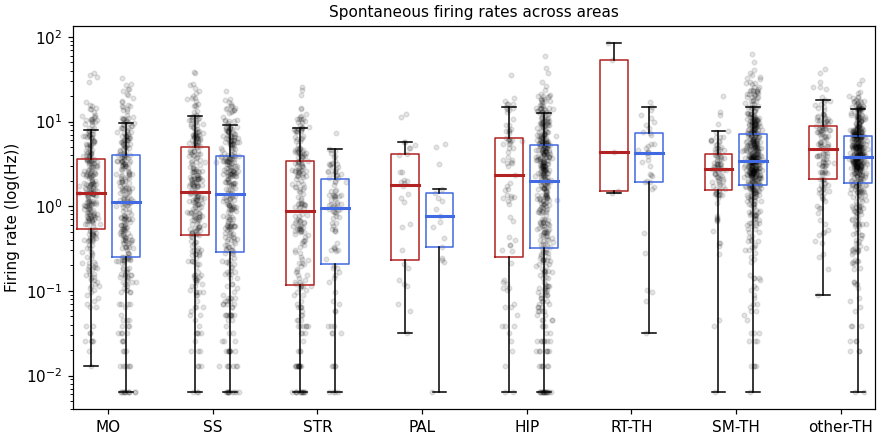

In [30]:
plot_regions = ['MO', 'SS', 'STR', 'PAL', 'HIP', 'RT-TH', 'SM-TH', 'other-TH']
compare = {'GAT1-KO': 'firebrick', 'wildtype': 'royalblue'}
locs = np.arange((len(compare) + 1) * len(plot_regions)).reshape((len(plot_regions), (len(compare) + 1)))
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
for ii, pregi in enumerate(plot_regions):
    for jj, (geno, gcol) in enumerate(compare.items()):
        FRvals = mega_pregion_df[
            (mega_pregion_df['genotype'] == geno) & (mega_pregion_df['parent_region'] == pregi)
        ]['firing_rate'].values
        FRvals = FRvals[np.nonzero(FRvals)]
        xs = np.random.normal(locs[ii,jj], 0.1, len(FRvals))
        ax.scatter(xs, FRvals, color='k', marker='.', alpha=0.1)
        ax.boxplot(
            FRvals, positions=[locs[ii,jj]], widths=[0.8], showfliers=False,
            medianprops={'color': gcol, 'linewidth': 2}, boxprops={'color': gcol}
        )
ax.semilogy()
ax.set_ylabel('Firing rate (log(Hz))')
ax.set_xticks(np.mean(locs[:,:-1], axis=1))
ax.set_xticklabels(plot_regions)
ax.set_title('Spontaneous firing rates across areas')

### SAVE ###
fig_name = 'multisub_spontFR.png'
fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

# Look at bursting in all areas???

In [35]:
print(np.unique(subject_df['genotype'].values))

['GAT1-KO' 'wildtype']


In [46]:
GAT_subs = subject_df[subject_df['genotype'] == 'GAT1-KO']['mouse'].values

all_pregion_list = {}
for mouse in GAT_subs:
    for pregi, regdf in all_subs_region_info[mouse].items():
        regdf['subject'] = [mouse] * len(regdf)
        if pregi not in all_pregion_list.keys():
            all_pregion_list[pregi] = [regdf]
        else:
            all_pregion_list[pregi].append(regdf)

all_pregion_dfs = {}
for pregi, regdf_list in all_pregion_list.items():
    all_pregion_dfs[pregi] = pd.concat(regdf_list, ignore_index=True)

In [49]:
len(all_pregion_dfs['MO'])

284

In [40]:
len(all_subs_region_info['644565']['MO'])

154

In [41]:
megatest = pd.concat([all_subs_region_info['645606']['MO'], all_subs_region_info['644565']['MO']])
print(len(megatest))
megatest.head()

284


,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,parent_region,firing_rate
0,F816,probeF,326,360,0.645561,MOp2/3,179,69,131,MO,1.224359
1,F806,probeF,322,400,1.030151,MOp2/3,180,71,132,MO,11.525641
2,F1022,probeF,318,440,0.714238,MOp2/3,180,72,133,MO,0.025641
3,F800,probeF,318,440,0.274707,MOp2/3,180,72,133,MO,5.961538
4,F797,probeF,314,480,0.247236,MOp2/3,180,74,133,MO,11.185897
